Dataset Import in Python & Feature Encoding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

# Load dataset
df = pd.read_csv('/media/maliciit/Data/Ali/MS Data Scince/Semester 1/4. Machine Learning/AI_ML Project/financial_fraud_detection_dataset.csv')  # Replace with your file path

print(f"Initial shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].sum() / len(df) * 100:.2f}%")
print(f"\nMissing values:\n{df.isnull().sum()}")

# ===== 1. HANDLE MISSING VALUES =====
df['fraud_type'].fillna('Unknown', inplace=True)
df['time_since_last_transaction'].fillna(df['time_since_last_transaction'].median(), inplace=True)

# ===== 2. DROP UNNECESSARY COLUMNS =====
df.drop(['transaction_id', 'ip_address', 'device_hash', 'timestamp'], axis=1, inplace=True)

# ===== 3. ENCODE CATEGORICAL FEATURES =====
# In your preprocessing code, change this line:
categorical_cols = ['transaction_type', 'merchant_category', 'location',
                    'device_used', 'payment_channel', 'fraud_type',
                    'sender_account', 'receiver_account']  # Added these 2

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ===== 4. SEPARATE FEATURES AND TARGET =====
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

# ===== 5. TRAIN/VAL/TEST SPLIT =====
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train fraud rate: {y_train.sum() / len(y_train) * 100:.2f}%")

# ===== 6. NORMALIZE NUMERIC FEATURES =====
numeric_cols = ['amount', 'time_since_last_transaction', 'spending_deviation_score',
                'velocity_score', 'geo_anomaly_score']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ===== 7. SAVE PREPROCESSED DATA =====
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save scaler and encoders
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("\n✓ Preprocessing complete! Files saved.")
print(f"Feature count: {X_train.shape[1]}")

Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Load original data (before preprocessing)
df = pd.read_csv('/media/maliciit/Data/Ali/MS Data Scince/Semester 1/4. Machine Learning/AI_ML Project/financial_fraud_detection_dataset.csv')

# ===== 1. CLASS DISTRIBUTION =====
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pie chart
fraud_counts = df['is_fraud'].value_counts()
axes[0, 0].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[0, 1].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].set_title('Fraud vs Non-Fraud Transactions', fontsize=14, fontweight='bold')
axes[0, 1].ticklabel_format(style='plain', axis='y')

# ===== 2. AMOUNT DISTRIBUTION =====
fraud_amounts = df[df['is_fraud']==1]['amount']
normal_amounts = df[df['is_fraud']==0]['amount']

axes[1, 0].hist([normal_amounts, fraud_amounts], bins=50, label=['Non-Fraud', 'Fraud'],
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1, 0].set_xlabel('Transaction Amount', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, df['amount'].quantile(0.95))  # Remove outliers for clarity

# ===== 3. FRAUD BY TRANSACTION TYPE =====
fraud_by_type = df.groupby('transaction_type')['is_fraud'].agg(['sum', 'count'])
fraud_by_type['rate'] = (fraud_by_type['sum'] / fraud_by_type['count'] * 100)
fraud_by_type = fraud_by_type.sort_values('rate', ascending=False)

axes[1, 1].barh(fraud_by_type.index, fraud_by_type['rate'], color='#e74c3c')
axes[1, 1].set_xlabel('Fraud Rate (%)', fontsize=12)
axes[1, 1].set_title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 4. RISK SCORES COMPARISON =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scores = ['spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
titles = ['Spending Deviation', 'Velocity Score', 'Geo Anomaly']

for idx, (score, title) in enumerate(zip(scores, titles)):
    axes[idx].boxplot([df[df['is_fraud']==0][score].dropna(),
                       df[df['is_fraud']==1][score].dropna()],
                      labels=['Non-Fraud', 'Fraud'],
                      patch_artist=True,
                      boxprops=dict(facecolor='#3498db'))
    axes[idx].set_ylabel('Score', fontsize=12)
    axes[idx].set_title(title, fontsize=14, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_risk_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 5. CORRELATION HEATMAP =====
# Prepare numeric data only
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 6. SUMMARY STATISTICS =====
print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal Transactions: {len(df):,}")
print(f"Fraudulent: {df['is_fraud'].sum():,} ({df['is_fraud'].mean()*100:.2f}%)")
print(f"Non-Fraudulent: {(df['is_fraud']==0).sum():,} ({(1-df['is_fraud'].mean())*100:.2f}%)")
print(f"\nAmount Statistics:")
print(f"  Mean: ${df['amount'].mean():,.2f}")
print(f"  Median: ${df['amount'].median():,.2f}")
print(f"  Fraud Mean: ${df[df['is_fraud']==1]['amount'].mean():,.2f}")
print(f"  Non-Fraud Mean: ${df[df['is_fraud']==0]['amount'].mean():,.2f}")
print("\n" + "="*60)

Testing of Stratification

In [ ]:
import pandas as pd

y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

print(f"Train fraud rate: {y_train['is_fraud'].mean()*100:.2f}%")
print(f"Val fraud rate: {y_val['is_fraud'].mean()*100:.2f}%")
print(f"Test fraud rate: {y_test['is_fraud'].mean()*100:.2f}%")

Neural Network Model (128 -> 64 -> 32 neurons)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# ===== DATASET CLASS (FINAL FIX) =====
class FraudDataset(Dataset):
    def __init__(self, X, y):
        X_numeric = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        self.X = torch.FloatTensor(X_numeric.values.astype(np.float32))

        # Handle y properly - force to 1D
        if isinstance(y, pd.DataFrame):
            y_values = y.values.flatten()
        else:
            y_values = y.values
        self.y = torch.FloatTensor(y_values.astype(np.float32))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===== MODEL ARCHITECTURE =====
class FraudDetectionNet(nn.Module):
    def __init__(self, input_size):
        super(FraudDetectionNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)

        x = self.relu(self.layer2(x))
        x = self.dropout2(x)

        x = self.relu(self.layer3(x))
        x = self.dropout3(x)

        x = self.output(x)
        return x  # Return [batch_size, 1] - DON'T squeeze here

# ===== TRAINING FUNCTION =====

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()  # Squeeze HERE for loss calculation
        loss = criterion(predictions, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# ===== VALIDATION FUNCTION =====
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            predictions = model(X_batch).squeeze()  # Squeeze HERE
            loss = criterion(predictions, y_batch)

            total_loss += loss.item()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return total_loss / len(loader), all_preds, all_labels

# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    X_train = pd.read_csv('/home/maliciit/ml-projects/python-projects/scripts/X_train.csv')
    y_train = pd.read_csv('/home/maliciit/ml-projects/python-projects/scripts/y_train.csv')
    X_val = pd.read_csv('/home/maliciit/ml-projects/python-projects/scripts/X_val.csv')
    y_val = pd.read_csv('/home/maliciit/ml-projects/python-projects/scripts/y_val.csv')

    # Create datasets
    train_dataset = FraudDataset(X_train, y_train)
    val_dataset = FraudDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FraudDetectionNet(input_size=13).to(device)

    # Loss and optimizer
    pos_weight = torch.tensor([26.8]).to(device)
    criterion = nn.BCELoss()  # Will handle weights manually in training
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nDevice: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Validation samples: {len(val_dataset):,}")
    print("\nModel ready for training!")


Loading data...

Device: cpu
Model parameters: 12,161
Training samples: 3,502,000
Validation samples: 748,000

Model ready for training!


Training

Loading data...

Device: cpu
Positive weight: 26.8
Starting training...

Epoch 1/20 | Train Loss: 1.3354 | Val Loss: 1.3353
  ✓ Best model saved
Epoch 2/20 | Train Loss: 1.3353 | Val Loss: 1.3353
  No improvement (1/5)
Epoch 3/20 | Train Loss: 1.3353 | Val Loss: 1.3353
  No improvement (2/5)
Epoch 4/20 | Train Loss: 1.3353 | Val Loss: 1.3353
  No improvement (3/5)
Epoch 5/20 | Train Loss: 1.3353 | Val Loss: 1.3353
  No improvement (4/5)
Epoch 6/20 | Train Loss: 1.3353 | Val Loss: 1.3353
  No improvement (5/5)

Early stopping at epoch 6

Training complete! Best val loss: 1.3353
✓ Training curves saved


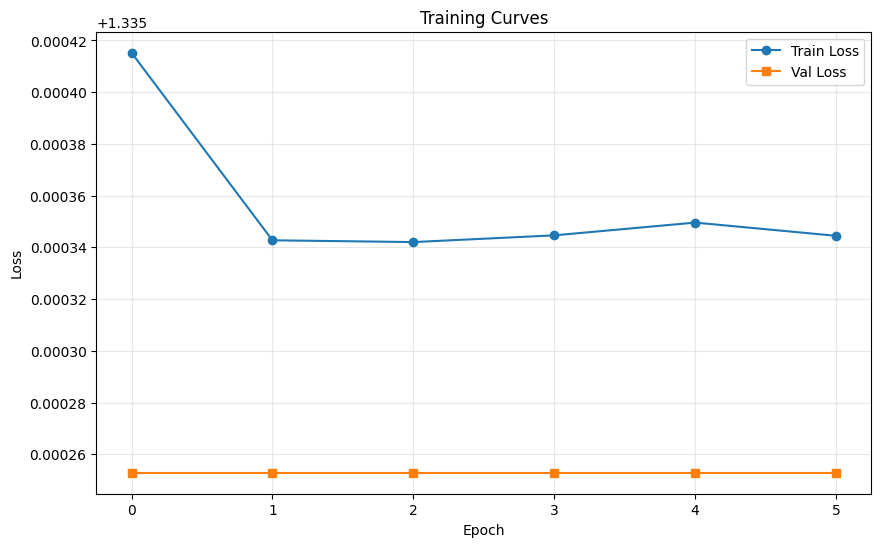

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from model import FraudDataset, FraudDetectionNet
import matplotlib.pyplot as plt
import time

# Configuration
EPOCHS = 20
PATIENCE = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 1024
POS_WEIGHT = 26.8  # Class imbalance ratio

# Load data
print("Loading data...")
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')['is_fraud']
y_train = pd.DataFrame({'is_fraud': y_train})
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')['is_fraud']
y_val = pd.DataFrame({'is_fraud': y_val})

train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudDetectionNet(input_size=X_train.shape[1]).to(device)

# Custom weighted loss function
pos_weight_tensor = torch.tensor([POS_WEIGHT]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nDevice: {device}")
print(f"Positive weight: {POS_WEIGHT}")
print(f"Starting training...\n")

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    # TRAINING
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ Best model saved")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Training curves saved")




Model Evaluation

Loading test data...
Generating predictions...

MODEL EVALUATION RESULTS

Test samples: 750,000
Actual frauds: 26,933.0
Predicted frauds: 750,000

              precision    recall  f1-score   support

   Non-Fraud       0.00      0.00      0.00    723067
       Fraud       0.04      1.00      0.07     26933

    accuracy                           0.04    750000
   macro avg       0.02      0.50      0.03    750000
weighted avg       0.00      0.04      0.00    750000

ROC-AUC Score: 0.5000


/home/maliciit/ml-projects/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maliciit/ml-projects/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/maliciit/ml-projects/ml-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi


✓ Confusion matrix saved
✓ ROC curve saved

Day 5-7 Evaluation Complete!


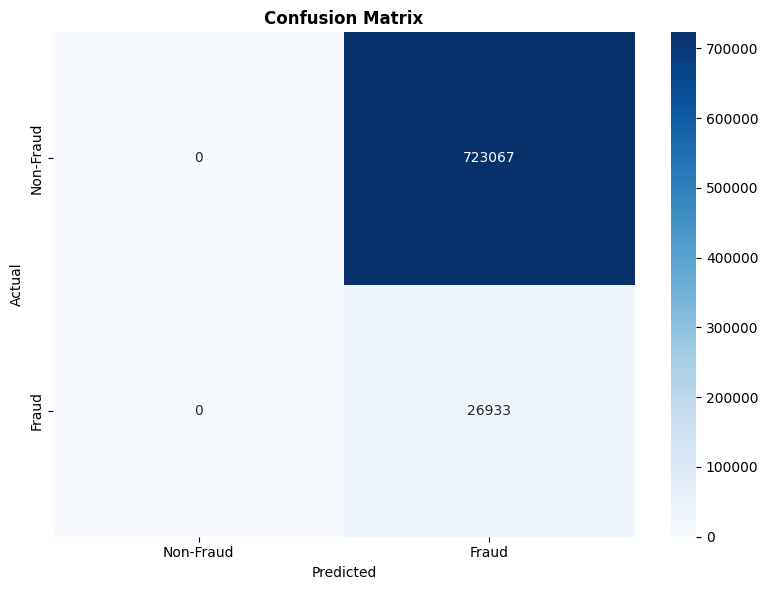

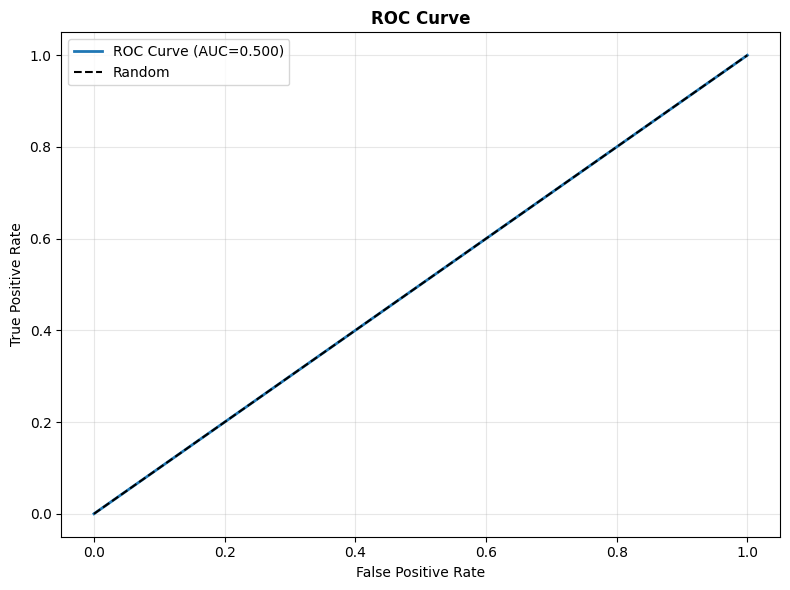

In [19]:
import torch
import pandas as pd
import numpy as np
from model import FraudDataset, FraudDetectionNet
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ===== LOAD TEST DATA =====
print("Loading test data...")
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')['is_fraud']
y_test = pd.DataFrame({'is_fraud': y_test})

test_dataset = FraudDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# ===== LOAD MODEL =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudDetectionNet(input_size=X_test.shape[1]).to(device)
model.load_state_dict(torch.load('final_model.pth', map_location=device))
model.eval()

# ===== GET PREDICTIONS =====
print("Generating predictions...")
all_preds = []
all_probs = []
all_labels = []

# In evaluate.py, change the prediction section:

# In the prediction loop:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze()  # Squeeze to get 1D
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_preds = (all_probs > 0.1).astype(int)

# ===== METRICS =====
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"\nTest samples: {len(all_labels):,}")
print(f"Actual frauds: {all_labels.sum():,}")
print(f"Predicted frauds: {all_preds.sum():,}")

print("\n" + classification_report(all_labels, all_preds, target_names=['Non-Fraud', 'Fraud']))

try:
    auc_score = roc_auc_score(all_labels, all_probs)
    print(f"ROC-AUC Score: {auc_score:.4f}")
except:
    print("ROC-AUC: Could not calculate")

# ===== CONFUSION MATRIX =====
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
print("\n✓ Confusion matrix saved")

# ===== ROC CURVE =====
try:
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300)
    print("✓ ROC curve saved")
except:
    pass

print("\nDay 5-7 Evaluation Complete!")

In [20]:
import torch
import pandas as pd
from model import FraudDataset, FraudDetectionNet
from torch.utils.data import DataLoader

# Load test data
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')['is_fraud']
y_test = pd.DataFrame({'is_fraud': y_test})

test_dataset = FraudDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Load model
device = torch.device('cpu')
model = FraudDetectionNet(input_size=X_test.shape[1]).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# Get first batch
X_batch, y_batch = next(iter(test_loader))
X_batch = X_batch.to(device)

# Check outputs
with torch.no_grad():
    raw_outputs = model(X_batch)
    probs = torch.sigmoid(raw_outputs)

    print("Raw outputs (logits):")
    print(f"  Min: {raw_outputs.min():.4f}")
    print(f"  Max: {raw_outputs.max():.4f}")
    print(f"  Mean: {raw_outputs.mean():.4f}")
    print(f"  Sample: {raw_outputs[:5]}")

    print("\nAfter sigmoid (probabilities):")
    print(f"  Min: {probs.min():.4f}")
    print(f"  Max: {probs.max():.4f}")
    print(f"  Mean: {probs.mean():.4f}")
    print(f"  Sample: {probs[:5]}")

    print("\nPredictions (threshold=0.5):")
    preds = (probs > 0.5).float()
    print(f"  Predicted as fraud: {preds.sum().item()}/{len(preds)}")

Raw outputs (logits):
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Sample: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

After sigmoid (probabilities):
  Min: 0.5000
  Max: 0.5000
  Mean: 0.5000
  Sample: tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]])

Predictions (threshold=0.5):
  Predicted as fraud: 0.0/1024
